In [1]:
import warnings
warnings.filterwarnings('ignore')

### Importing the packages nessacary to run the modeling functions

In [2]:
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import json

### Reading in the json file that contains the fires filtered out in the given dates from 1963 to 2023.

In [3]:
df = pd.read_json("filtered_fires_1963_to_2023.json")

In [6]:
df.head()

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,distance,smoke_estimate
0,14299,14299,Wildfire,1963,1,"1 (1), 3 (3)",40992.458271,16589.059302,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,Prescribed fire data in this dataset represent...,None,None,0.385355,NaN,No,73550.428118,1.658906e+08,521.214447,157.295940
1,14300,14300,Wildfire,1963,1,"1 (1), 3 (3)",25757.090203,10423.524591,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,Prescribed fire data in this dataset represent...,None,None,0.364815,NaN,No,59920.576713,1.042352e+08,525.120981,98.099642
2,14301,14301,Wildfire,1963,1,"1 (5), 3 (15), 5 (1)",45527.210986,18424.208617,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (6), Likely Wildfire (15)",...,Prescribed fire data in this dataset represent...,None,None,0.320927,NaN,No,84936.827810,1.842421e+08,531.964002,171.166511
3,14302,14302,Wildfire,1963,1,"1 (1), 3 (3), 5 (1)",10395.010334,4206.711433,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (3)",...,Prescribed fire data in this dataset represent...,None,None,0.428936,NaN,No,35105.903602,4.206711e+07,477.534104,43.536201
4,14303,14303,Wildfire,1963,1,"1 (1), 3 (3)",9983.605738,4040.221900,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,Prescribed fire data in this dataset represent...,None,None,0.703178,NaN,No,26870.456126,4.040222e+07,516.640086,38.648204


In [7]:
df.columns

Index(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'distance', 'smoke_estimate'],
      dtype='object')

### Selecting columns relevant to my analysis

In [4]:
df_fires = df[['Fire_Year', 'USGS_Assigned_ID', 'Listed_Fire_Names', 'Listed_Fire_Types', 'Assigned_Fire_Type', 'Listed_Fire_Dates', 'GIS_Acres', 'distance', 'smoke_estimate']]

In [5]:
df_fires.head()

,Fire_Year,USGS_Assigned_ID,Listed_Fire_Names,Listed_Fire_Types,Assigned_Fire_Type,Listed_Fire_Dates,GIS_Acres,distance,smoke_estimate
0,1963,14299,RATTLESNAKE (4),"Wildfire (1), Likely Wildfire (3)",Wildfire,Listed Wildfire Discovery Date(s): 1963-08-06 ...,40992.458271,521.214447,157.295940
1,1963,14300,"McChord Butte (2), No Fire Name Provided (1), ...","Wildfire (2), Likely Wildfire (2)",Wildfire,Listed Wildfire Discovery Date(s): 1963-07-28 ...,25757.090203,525.120981,98.099642
2,1963,14301,"WILLOW CREEK (16), EAST CRANE CREEK (4), Crane...","Wildfire (6), Likely Wildfire (15)",Wildfire,Listed Wildfire Discovery Date(s): 1963-08-06 ...,45527.210986,531.964002,171.166511
3,1963,14302,"SOUTH CANYON CREEK (4), No Fire Name Provided (1)","Wildfire (2), Likely Wildfire (3)",Wildfire,Listed Wildfire Discovery Date(s): 1963-08-06 ...,10395.010334,477.534104,43.536201
4,1963,14303,WEBB CREEK (4),"Wildfire (1), Likely Wildfire (3)",Wildfire,Listed Wildfire Discovery Date(s): 1963-08-06 ...,9983.605738,516.640086,38.648204


### Group by 'Fire_Year' and calculate the sum of 'smoke_estimate' for each year

In [10]:
annual_smoke_estimates = df_fires.groupby('Fire_Year')['smoke_estimate'].sum().reset_index()

In [11]:
df_annual = df_fires.groupby('Fire_Year')['smoke_estimate'].mean().reset_index()

In [12]:
df_annual.head()

,Fire_Year,smoke_estimate
0,1963,3.592129
1,1964,11.861418
2,1965,5.315415
3,1966,12.675489
4,1967,7.951785


### Modeling the data

In [ ]:
"""
Perform Exponential Smoothing for forecasting mean annual smoke estimates based on historical data.

Parameters:
    - df_annual (DataFrame): Input DataFrame containing columns 'Fire_Year' and 'smoke_estimate'.
    - forecast_horizon (int): Number of years to forecast into the future (e.g., 2021 to 2049).

Returns:
    - forecasted_values (array-like): Forecasted mean annual smoke estimates for the specified horizon.

Description:
1. Train-Validation Split: Split the input DataFrame into training and validation sets. Data up to the year 2019 is used for training, while data from the year 2020 is used for validation.

2. Model Selection (Exponential Smoothing): Select the Exponential Smoothing model with additive trend and seasonal components. Seasonal periods are set to 12, assuming a yearly seasonality.

3. Model Fitting: Fit the selected model to the training data.

4. Model Evaluation on Validation Set: Generate predictions on the validation set and calculate the Root Mean Squared Error (RMSE) to evaluate the model's performance.

5. Forecasting: Use the trained model to forecast mean annual smoke estimates for the specified forecast horizon (2021 to 2049).

6. Plotting: Visualize the actual historical data and the forecasted values using a line plot. The actual data is represented by a solid line, while the forecasted values are shown as dashed lines.
"""

RMSE on Validation Set: 8.578566207532408


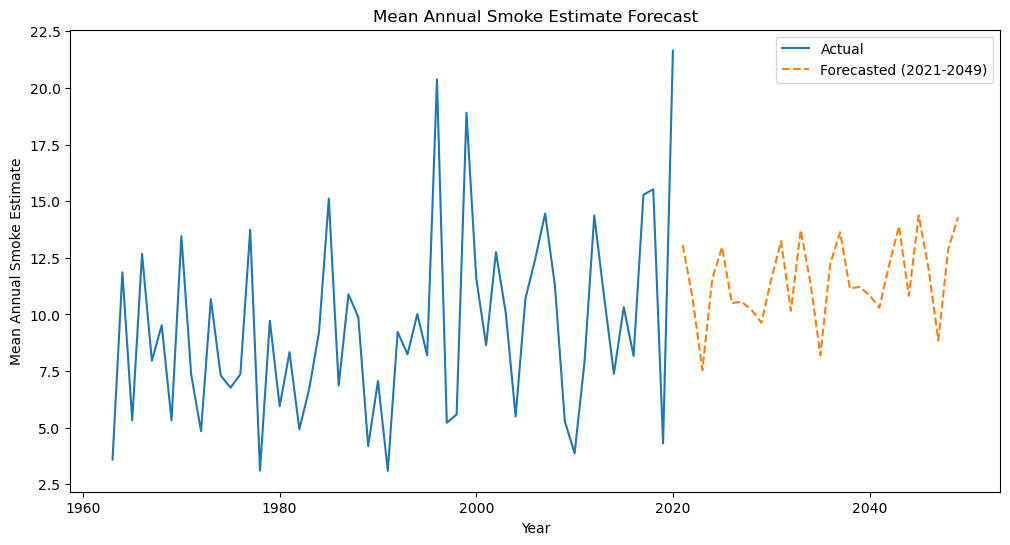

In [13]:
# Train-Validation Split (up to 2019 for training and 2020 for validation)
train = df_annual[df_annual['Fire_Year'] <= 2019]
validation = df_annual[df_annual['Fire_Year'] == 2020]

# Model Selection (Exponential Smoothing)
model = ExponentialSmoothing(train['smoke_estimate'], trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Model Evaluation on Validation Set
validation['predictions'] = model_fit.forecast(len(validation))
rmse = sqrt(mean_squared_error(validation['smoke_estimate'], validation['predictions']))
print("RMSE on Validation Set:", rmse)

# Forecasting
forecast_horizon = 29  # 2021 to 2049
forecasted_values = model_fit.forecast(forecast_horizon)

# Plot actual vs. forecasted cumulative smoke estimates
plt.figure(figsize=(12, 6))
plt.plot(df_annual['Fire_Year'], df_annual['smoke_estimate'], label='Actual')
plt.plot(range(2021, 2050), forecasted_values, label='Forecasted (2021-2049)', linestyle='--')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Mean Annual Smoke Estimate')
plt.title('Mean Annual Smoke Estimate Forecast')
plt.show()

### Graph showing number of fires by distance from Merced, CA

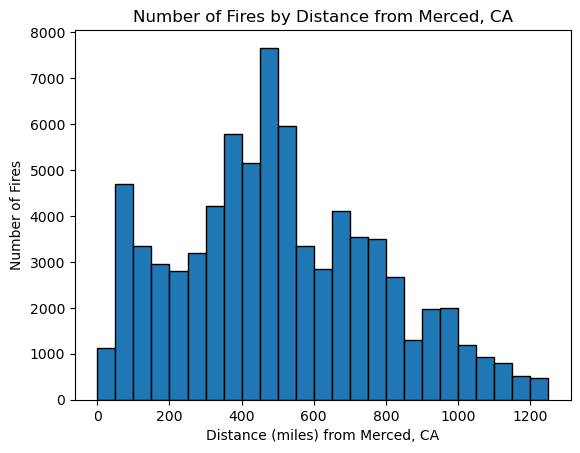

In [14]:
# Filter data for the years 1963 to 2020
d = df_fires[(df_fires['Fire_Year'] >= 1963) & (df_fires['Fire_Year'] <= 2020)]

# Create a histogram of fires by distance
max_distance = round(d['distance'].max())
bin_width = 50
bins = range(0, max_distance + bin_width, bin_width)
plt.hist(df_fires['distance'], bins=bins, edgecolor='k')
plt.xlabel('Distance (miles) from Merced, CA')
plt.ylabel('Number of Fires')
plt.title('Number of Fires by Distance from Merced, CA')
plt.show()

### Graph showing total acres of forests burned per year due to wildfires near Merced, CA

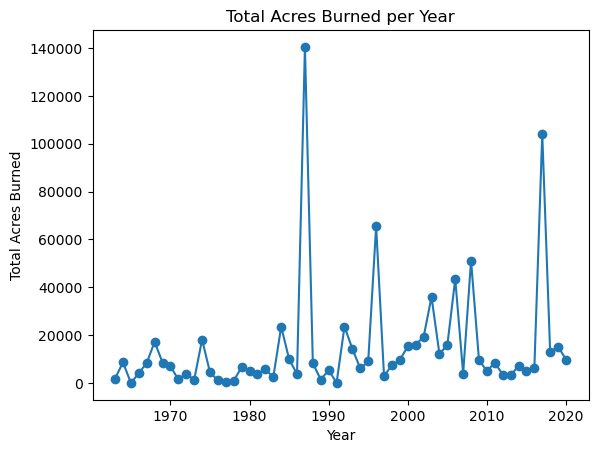

In [15]:
# Filter data for the specified distance (e.g., 0-50 miles from your city)
specified_distance_data = df_fires[(df_fires['distance'] >= 0) & (df_fires['distance'] <= 50)]

# Group data by year and calculate the total acres burned per year
acres_burned_per_year = specified_distance_data.groupby('Fire_Year')['GIS_Acres'].sum()

# Plot the time series
plt.plot(acres_burned_per_year.index, acres_burned_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned per Year')
plt.show()

### Generating a time-series graph for Fire Smoke Estimate and AQI over Time

In [ ]:
"""
Load and preprocess air quality data and wildfire smoke estimates to create a time series plot.

Parameters:
    - None

Returns:
    - None

Description:
1. Load Air Quality Index (AQI) Data: Load AQI data from a JSON file ('aqi_yearly_means_1992_to_2020.json') and normalize the AQI values by dividing them by the maximum AQI value.

2. Create DataFrame for AQI Data: Convert the loaded data into a pandas DataFrame ('df_aqi_data') with columns 'Fire_Year' and 'AQI', where 'Fire_Year' is converted to integer type.

3. Normalize Smoke Estimate Data: Normalize the smoke estimate values by dividing them by the maximum smoke estimate value. Create a DataFrame ('df_smoke_estimate') with columns 'Fire_Year' and 'smoke_estimate'.

4. Filter and Group Smoke Estimate Data: Keep data from 1992 to 2020 and group the smoke estimate data by year, calculating the mean for each year.

5. Merge DataFrames: Merge the normalized smoke estimate and AQI DataFrames based on the 'Fire_Year' column into a new DataFrame ('merged_df').

6. Plotting Time Series Graph: Create a time series plot with years on the x-axis and normalized values on the y-axis. Plot both smoke estimates and AQI values, marking each data point with markers.
"""

In [ ]:
with open('aqi_yearly_means_1992_to_2020.json', 'r') as f:
    data = json.load(f)
    
df_aqi_data = pd.DataFrame(list(data.items()), columns=['Fire_Year', 'AQI'])
df_aqi_data['Fire_Year'] = df_aqi_data['Fire_Year'].astype(int)
df_aqi_data['AQI'] = df_aqi_data['AQI'] / df_aqi_data['AQI'].max()

df_smoke_estimate = df_fires[['Fire_Year', 'smoke_estimate']]
df_smoke_estimate = df_smoke_estimate.groupby('Fire_Year')['smoke_estimate'].mean().reset_index()
df_smoke_estimate = df_smoke_estimate[(df_smoke_estimate['Fire_Year'] >= 1992) & (df_smoke_estimate['Fire_Year'] <= 2020)]
df_smoke_estimate['smoke_estimate'] = df_smoke_estimate['smoke_estimate'] / df_smoke_estimate['smoke_estimate'].max()

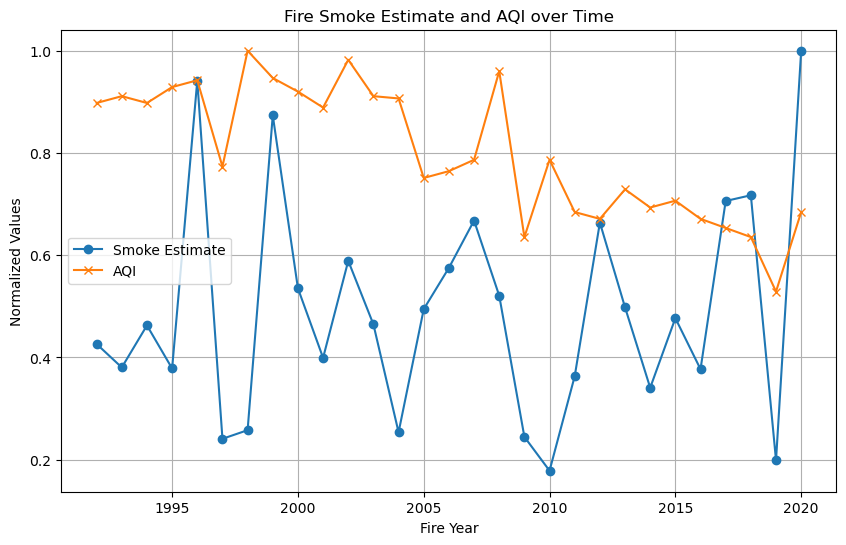

In [9]:
# Merge the two DataFrames on the 'Fire_Year' column
merged_df = df_smoke_estimate.merge(df_aqi_data, on='Fire_Year')

# Plot the time series graph
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Fire_Year'], merged_df['smoke_estimate'], label='Smoke Estimate', marker='o')
plt.plot(merged_df['Fire_Year'], merged_df['AQI'], label='AQI', marker='x')

plt.xlabel('Fire Year')
plt.ylabel('Normalized Values')
plt.title('Fire Smoke Estimate and AQI over Time')
plt.legend()
plt.grid(True)
plt.show()

### Generating a time-series graph for Fire Smoke Estimate and AQI over Time

In [ ]:
"""
Load air quality index (AQI) data from a JSON file containing yearly means for the years 1992 to 2020.
Normalize the AQI values and create a pandas DataFrame. Additionally, process and normalize smoke estimates
from another DataFrame containing fire-related data. Merge the two DataFrames on the 'Fire_Year' column and
plot a time series graph to visualize the trends of smoke estimates and AQI over the specified time period.

Parameters:
-----------
None

Returns:
--------
None

Usage:
------
1. Ensure the 'aqi_yearly_means_1992_to_2020.json' file is available in the working directory.
2. Make sure the 'df_fires' DataFrame containing fire-related data is available.
3. Execute the code to load, process, and visualize the AQI and smoke estimate trends over time.
   The resulting plot will display normalized values for better comparison.
"""

In [39]:
df_pre_death_rate = pd.read_csv('premature_death_rate.csv')
df_pre_death_rate['DATE'] = df_pre_death_rate['DATE'].str[-4:]
df_pre_death_rate = df_pre_death_rate.rename(columns={'DATE': 'Fire_Year', 'CDC20N2U006047' : 'Deaths'})
df_pre_death_rate['Deaths'] = df_pre_death_rate['Deaths'] / df_pre_death_rate['Deaths'].max()
merged_df_subset = merged_df[(merged_df['Fire_Year'] >= 1999) & (merged_df['Fire_Year'] <= 2020)]
merged_df_subset['Fire_Year'] = merged_df_subset['Fire_Year'].astype(str)
df_smoke_aqi_deaths = merged_df_subset.merge(df_pre_death_rate, on='Fire_Year')

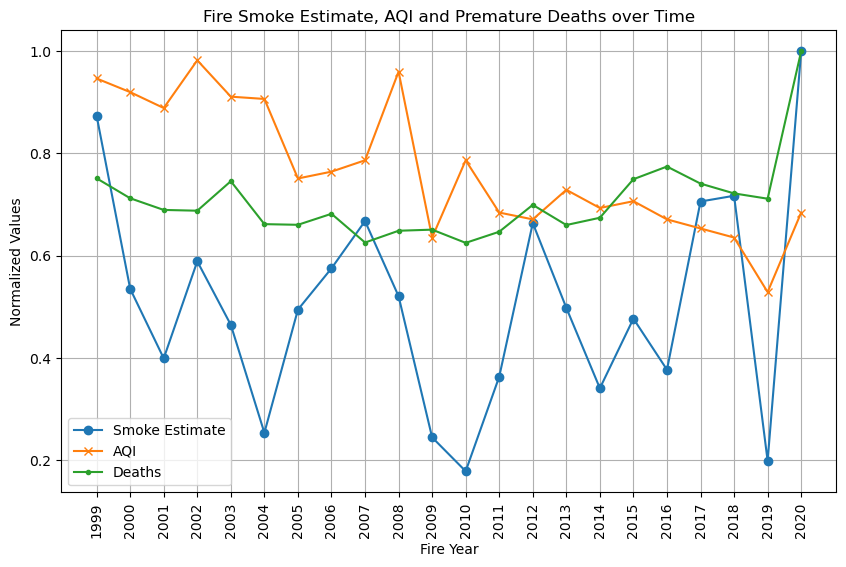

In [50]:
# Plot the time series graph
plt.figure(figsize=(10, 6))
plt.plot(df_smoke_aqi_deaths['Fire_Year'], df_smoke_aqi_deaths['smoke_estimate'], label='Smoke Estimate', marker='o')
plt.plot(df_smoke_aqi_deaths['Fire_Year'], df_smoke_aqi_deaths['AQI'], label='AQI', marker='x')
plt.plot(df_smoke_aqi_deaths['Fire_Year'], df_smoke_aqi_deaths['Deaths'], label='Deaths', marker='.')

plt.xlabel('Fire Year')
plt.xticks(rotation=90)
plt.ylabel('Normalized Values')
plt.title('Fire Smoke Estimate, AQI and Premature Deaths over Time')
plt.legend()
plt.grid(True)
plt.show()